Run using keras kernel!

In [222]:
from itertools import zip_longest
import cv2
import numpy as np
import csv
import os, errno

def file_len(fname):
    i = -1
    with open(fname) as f:
        for i, l in enumerate(f):
            pass
    return i + 1

def remove(filename):
    try:
        os.remove(filename)
    except OSError as e:
        if e.errno != errno.ENOENT:
            raise

def clean_driving_log(logfile, img_dir):
    with open(logfile,'r') as r, open('clean_log.csv','w') as w:
        reader = csv.reader(r, delimiter=',')
        writer = csv.writer(w, delimiter=',')
        for row in reader:
            img_file = img_dir + row[0]
            if (os.path.isfile(img_file)):
                writer.writerow(row)
                
            
def split_driving_log(f, train_percent, seed=1973):
    ft = open('train_log.csv','w')
    fv = open('valid_log.csv','w')
    np.random.seed(seed)
    with open(f, 'r') as f:
        for line in f:
            if (np.random.random() <= train_percent):
                ft.write(line)
            else:
                fv.write(line)
    ft.close()
    fv.close()

def grouper(iterable, n, fillvalue=None):
    args = [iter(iterable)] * n
    return zip_longest(*args, fillvalue=fillvalue)

def load_image(f):
    img = cv2.imread(f,-1)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    return img 

def extract_csv(log):
    fs = []
    ys = []
    with open(log,'r') as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        for row in reader:
            fs.append(row[0])
            ys.append(row[3])
    return fs, ys

            
def generator_random(n, img_dir, logfile):
    f, y = extract_csv(logfile)
    l = len(f)
    while True:
        xs = []
        ys = []
        for _ in range(n):
            i = np.random.randint(low=0,high=l)
            img = load_image(img_dir+f[i])
            xs.append(img)
            ys.append(y[i])
        yield (np.asarray(xs), np.asarray(ys))

def generator_all(img_dir, logfile):
    f, y = extract_csv(logfile)
    l = len(f)
    while True:
        xs = []
        ys = []
        for i in range(l):
            img = load_image(img_dir+f[i])
            xs.append(img)
            ys.append(y[i])
        yield (np.asarray(xs), np.asarray(ys))

   

(160, 320, 3)

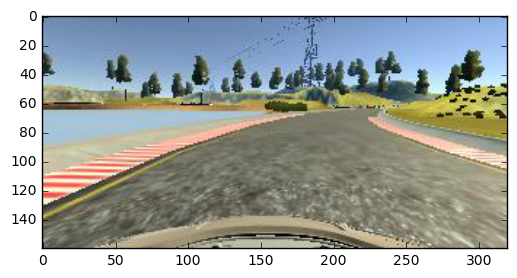

In [223]:
import matplotlib.pyplot as plt
%matplotlib inline

g = generator_random(1, 'data/images_run01/','data/driving_log_3.csv')

x,y = g.__next__()

plt.imshow(x[0])
x[0].shape

In [224]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Lambda, ELU
from keras.layers.convolutional import Convolution2D
from keras.optimizers import Adam 

def get_model():
    ch, row, col = 3, 160, 320  # camera format

    model = Sequential()
    model.add(Lambda(lambda x: x/127.5 - 1.,
            input_shape=( row, col, ch),
            output_shape=( row, col, ch)))
    model.add(Convolution2D(16, 8, 8, subsample=(4, 4), border_mode="same"))
    model.add(ELU())
    model.add(Convolution2D(32, 5, 5, subsample=(2, 2), border_mode="same"))
    model.add(ELU())
    model.add(Convolution2D(64, 5, 5, subsample=(2, 2), border_mode="same"))
    model.add(Flatten())
    model.add(Dropout(.2))
    model.add(ELU())
    model.add(Dense(512))
    model.add(Dropout(.5))
    model.add(ELU())
    model.add(Dense(1))

    my_adam = Adam(lr=0.00001)
    model.compile(optimizer=my_adam, loss="mse")

    return model


model = get_model()

remove('clean_log.csv')
remove('train_log.csv')
remove('valid_log.csv')
remove('model.json')
remove('model.h5')

image_dir = 'data/images_run01/'
clean_driving_log('data/driving_log_3.csv', image_dir)
split_driving_log('clean_log.csv',0.5)

n_train = file_len('train_log.csv')
n_valid = file_len('valid_log.csv')

print(n_train, n_valid)

early_stopping_patience = 10
epochs_since_better = 0
n_epochs = 20
continue_training = True
consider_stopping = False
best_mse = float("inf")
n_epoch = 0

batch_size = 1
n_batches = n_train / batch_size


while n_epoch < n_epochs and continue_training:
    
    model.fit_generator(
        generator_random(batch_size, image_dir,'train_log.csv'),
        samples_per_epoch=n_batches,
        nb_epoch=1)

    mse = model.evaluate_generator(
        generator_all(image_dir,'valid_log.csv'),
        val_samples = 1)
    
    print(mse)
    
    # Early stopping?
    if mse > best_mse:    
        if consider_stopping:
            epochs_since_better += 1
        else:
            consider_stopping = True
            epochs_since_better = 1
    else:
        print('Improved accuracy of {} at epoch {}'.format(mse,n_epoch))
        best_mse = mse
        json = model.to_json()
        with open('model.json', 'w') as f:
            f.write(json)  
        model.save_weights('model.h5')
        consider_stopping = False

    if epochs_since_better > early_stopping_patience:
        print('Stopping no improvement for {} epochs'.format(early_stopping_patience))
        continue_training = False

    
    n_epoch += 1


2 1
Epoch 1/1
2/2 [==============================] - 1s - loss: 0.0019     
0.21141988039
Improved accuracy of 0.21141988039016724 at epoch 0
Epoch 1/1
2/2 [==============================] - 0s - loss: 0.0731     
0.206001922488
Improved accuracy of 0.20600192248821259 at epoch 1
Epoch 1/1
2/2 [==============================] - 0s - loss: 0.0024     
0.199521437287
Improved accuracy of 0.19952143728733063 at epoch 2
Epoch 1/1
2/2 [==============================] - 0s - loss: 0.0461     
0.199791833758
Epoch 1/1
2/2 [==============================] - 0s - loss: 0.0355     
0.200397416949
Epoch 1/1
2/2 [==============================] - 0s - loss: 0.0210     
0.205239221454
Epoch 1/1
2/2 [==============================] - 0s - loss: 0.0129     
0.210726380348
Epoch 1/1
2/2 [==============================] - 0s - loss: 0.0067     
0.212648287416
Epoch 1/1
2/2 [==============================] - 0s - loss: 0.0024         
0.212676003575
Epoch 1/1
2/2 [==============================] - 0s - 

In [225]:
from keras.models import model_from_json

with open('model.json', 'r') as f:
    json = f.read()
model2 = model_from_json(json)

model2

## Image Augmentation
 
1. Remove top 60 pixels and bottom 20 (160, 320) -> (80, 320)
2. Rescale to (80, 160)
3. Randomly darken and brighten




(160, 320, 3)
(80, 160, 3)


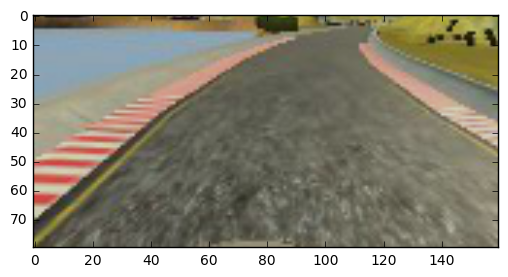

In [226]:
#def process_image(img):

print(x[0].shape)
img = x[0][60:140,:,:]
img = cv2.resize(img,(160, 80))
plt.imshow(img)

img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
img[:,:,2] = img[:,:,2] * ( 0.5 + np.random.uniform() )
img = cv2.cvtColor(img, cv2.COLOR_HSV2RGB)
plt.imshow(img)

print(img.shape)

### An infinite generator

0.366769403219223 0.5504056897715242


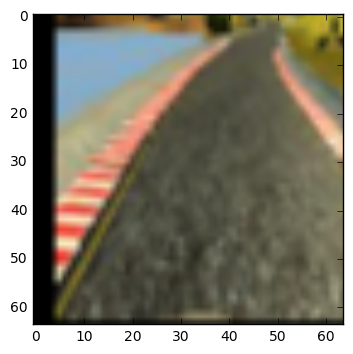

In [227]:
def gamma_correction(img, correction):
    img = img/255.0
    img = cv2.pow(img, correction)
    return np.uint8(img*255)

img = x[0]
angle = np.float32(y)[0]

X_OFFSET_RANGE = 10
Y_OFFSET_RANGE = 10

img = x[0][60:140,:,:]
img = cv2.resize(img,(64, 64))

# 0.2 - 4
bright_factor = 0.2 + (3.8 * np.random.uniform())
img = gamma_correction(img, bright_factor)

if (np.random.uniform() > 0.5):
    img = np.fliplr(img)
    angle = -angle


x_translation = (X_OFFSET_RANGE * np.random.uniform()) - (X_OFFSET_RANGE / 2)
y_translation = (Y_OFFSET_RANGE * np.random.uniform()) - (Y_OFFSET_RANGE / 2)

angle = angle + ((x_translation / X_OFFSET_RANGE) * 2) * 0.2

translation_matrix = np.float32([[1, 0, x_translation], [0, 1, y_translation]])
img = cv2.warpAffine(img, translation_matrix, (img.shape[1], img.shape[0]))
 
print('{} {}'.format(np.float32(y)[0], angle))
plt.imshow(img)


In [351]:
def extract_csv(log):
    f = []
    y = []
    with open(log,'r') as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        for row in reader:
            f.append(row[0].strip())
            y.append(np.float32(row[3]))
            f.append(row[1].strip())
            y.append(np.float32(row[3])+0.2)
            f.append(row[2].strip())
            y.append(np.float32(row[3])-0.2)
    return f, y

def generate_image(img, y):
    
    angle = y

    X_OFFSET_RANGE = 10
    Y_OFFSET_RANGE = 10
    X_OFFSET_ANGLE = 0.2
    
    img = img[60:140,:,:]
    img = cv2.resize(img,(64, 64))

    bright_factor = 0.2 + (3.8 * np.random.uniform())
    img = gamma_correction(img, bright_factor)

    if (np.random.uniform() > 1.0):
        img = np.fliplr(img)
        angle = -1.0 * angle

    x_translation = (X_OFFSET_RANGE * np.random.uniform()) - (X_OFFSET_RANGE / 2)
    y_translation = (Y_OFFSET_RANGE * np.random.uniform()) - (Y_OFFSET_RANGE / 2)

    angle = angle + ((x_translation / X_OFFSET_RANGE) * 2) * X_OFFSET_ANGLE
    t = np.float32([[1, 0, x_translation], [0, 1, y_translation]])
    img = cv2.warpAffine(img, t, (img.shape[1], img.shape[0]))

    return (img, angle)


def generator_random(n, img_dir, logfile):
    f, y = extract_csv(logfile)
    l = len(f)
    while True:
        xs = []
        ys = []
        for _ in range(n):
            i = np.random.randint(low=0,high=l)
            img, angle = generate_image(load_image(img_dir+f[i]),y[i])
            xs.append(img)
            ys.append(angle)
        yield (np.asarray(xs), np.asarray(ys))

def generator_random_zero(n, img_dir, logfile):
    f, y = extract_csv(logfile)
    l = len(f)
    while True:
        xs = []
        ys = []
        for _ in range(n):
            i = np.random.randint(low=0,high=l)
            if ( (np.float32(y[i]) >= -0.01 
                    and np.float32(y[i]) <= 0.01 ) 
                    and np.random.uniform() > 0.1 ):
                while (np.float32(y[i]) >= -0.01 
                       and np.float32(y[i]) <= 0.01):
                    i = np.random.randint(low=0,high=l)
            elif ( (np.float32(y[i]) >= -0.21 
                    and np.float32(y[i]) <= -0.19 ) 
                    and np.random.uniform() > 0.1 ):
                while (np.float32(y[i]) >= -0.21 
                       and np.float32(y[i]) <= -0.19):
                    i = np.random.randint(low=0,high=l)
            elif ( (np.float32(y[i]) >= 0.19 
                    and np.float32(y[i]) <= 0.21 ) 
                    and np.random.uniform() > 0.1 ):
                while (np.float32(y[i]) >= 0.19 
                       and np.float32(y[i]) <= 0.21):
                    i = np.random.randint(low=0,high=l)
            img, angle = generate_image(load_image(img_dir+f[i]),np.float32(y[i]))
            xs.append(img)
            ys.append(y[i])
        yield (np.asarray(xs), np.asarray(ys))
        
image_dir = 'data/images_run01/'
g = generator_random(10, image_dir,'train_log.csv')

x, y = g.__next__()

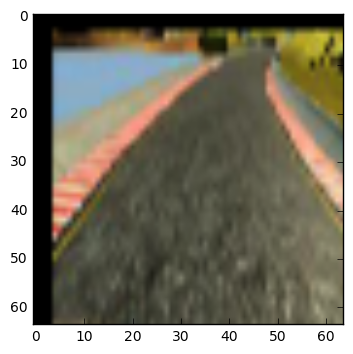

In [338]:
plt.imshow(x[6])

In [352]:
def clean_driving_log(logfile, img_dir):
    with open(logfile,'r') as r, open('clean_log.csv','w') as w:
        reader = csv.reader(r, delimiter=',')
        writer = csv.writer(w, delimiter=',')
        for row in reader:
            imgc_file = img_dir + row[0].strip()
            imgl_file = img_dir + row[1].strip()
            imgr_file = img_dir + row[2].strip()
            if (os.path.isfile(imgc_file) & os.path.isfile(imgl_file) & os.path.isfile(imgr_file)):
                writer.writerow(row)
                
image_dir = 'data/images_run01/'
clean_driving_log('driving_log.csv', image_dir)
g = generator_random_zero(10000, image_dir,'clean_log.csv')
images, angle = g.__next__()
angle = np.float32(angle)

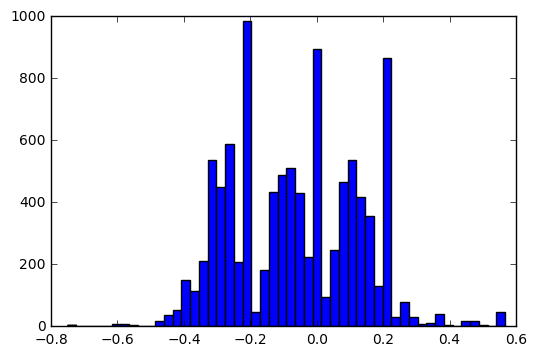

In [353]:
angle[angle==0].shape
#angle.shape
angle[0:100]
p = plt.hist(angle, bins=50)

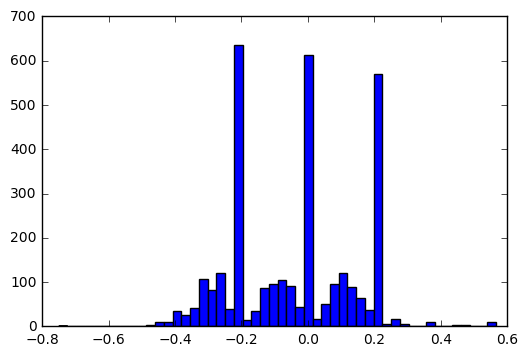

In [354]:
f, y = extract_csv('clean_log.csv')
p = plt.hist(np.float32(y), bins = 50)

OK - so when I come back to this... I always add 0.2 to the left and right images which means we have too many of those as well as 0.  We need to down sample the images at -0.2, 0 and +0.2.  The histogram above shows the distribution of the driving log from 2 laps of the track.  The histogram above that shows the distribution of the data from the generator.  It down samples these values.

Note that I now combine all the images a nd make steering adjustments in the in the extract csv function.  This will simplify the generator and needs rolling into the model.py code base.  

I would also like to see the above plots for the main training data set I have on AWS.  

Steps to go forward:

1. Create working model.py which uses this generator.
2. Check distribution of the training data including forward, backward laps plus recovery data.
3. Move code to AWS and power up the GPUs!

Use current model architecture with dropout.  Can now train with ridiculous quantities of training data which will limit overfitting.  For the rubric we should be using validation data - I still think we want the model which generalises best so I suggest using more data and stopping when validation does not improve. 

Remember to quote and thank input from these folks:

https://chatbotslife.com/using-augmentation-to-mimic-human-driving-496b569760a9#.8bmsj5uy8

https://medium.com/@mohankarthik/cloning-a-car-to-mimic-human-driving-5c2f7e8d8aff#.920b3dn9t



